In [224]:
import numpy as np
import pandas as pd 
from xgboost import XGBRegressor 
from sklearn.model_selection import TimeSeriesSplit
import warnings              
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from datetime import datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 9]
from sklearn.preprocessing import StandardScaler
from itertools import product                   
from sklearn.model_selection import cross_val_score
from scipy.optimize import minimize         
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
warnings.filterwarnings('ignore')
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing, HoltWintersResults

In [225]:
train = pd.read_csv("ts_train.csv")
test = pd.read_csv("ts_test.csv")

In [226]:
def select_ts(index):
    return (train[train.tsID == index].copy(),
            test[test.tsID == index].copy())

In [227]:
def tscrossvalid(params, series, loss_function=mean_squared_error):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):
        
        model = ExponentialSmoothing(values[train] ,seasonal_periods=365, 
                                    trend='add', seasonal='add')
        
        fit1 = model.fit(smoothing_level = alpha, 
                         smoothing_slope = beta,
                         smoothing_seasonal = gamma)
        
        y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))

        
        
        predictions = y_hat_avg['Holt_Winter'][-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In [228]:
def optimizer(data):
    # initializing model parameters alpha, beta and gamma
    x = [0, 0, 0] 

    # Minimizing the loss function 
    opt = minimize(tscrossvalid, x0=x, 
                   args=(data, mean_squared_error), 
                   method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
                  )

    # Take optimal values...
    alpha_final, beta_final, gamma_final = opt.x
    return(alpha_final, beta_final, gamma_final)

In [229]:
def main(i, s):
    train_n, test_n = select_ts(i)
    data = np.array(train_n.ACTUAL)
    
    y_hat_avg = test_n.copy()
    fit1 = ExponentialSmoothing(np.asarray(data), seasonal_periods=s,
                                trend='add', seasonal='add',).fit(optimized = True)
    y_hat_avg['Holt_Winter'] = fit1.forecast(300)
    predictions = y_hat_avg['Holt_Winter']
    
    plt.figure(figsize=(16,8))
    plt.plot(train_n.ID, train_n.ACTUAL, label='Train')
    plt.plot(test_n.ID, predictions, label='Holt_Winter')
    plt.legend(loc='best')
    plt.show()

    df = pd.Series(np.array(predictions), index = test_n.ID)
    return df

1


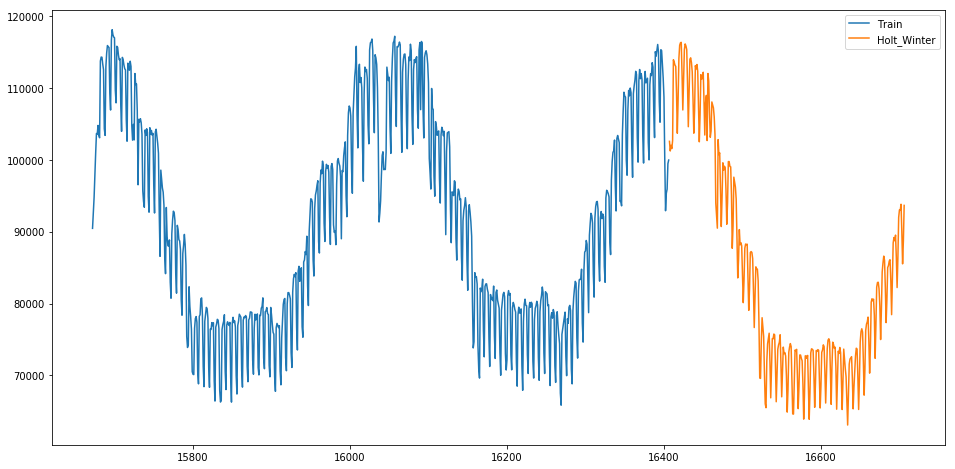

2


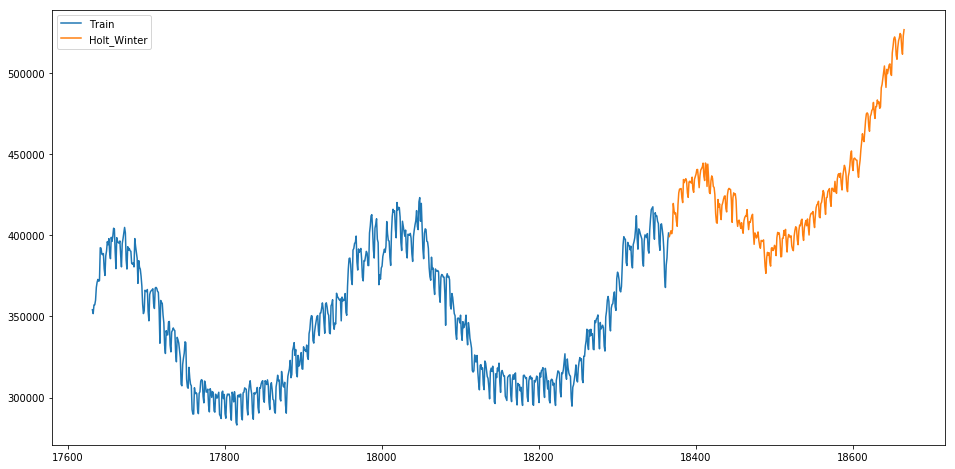

3


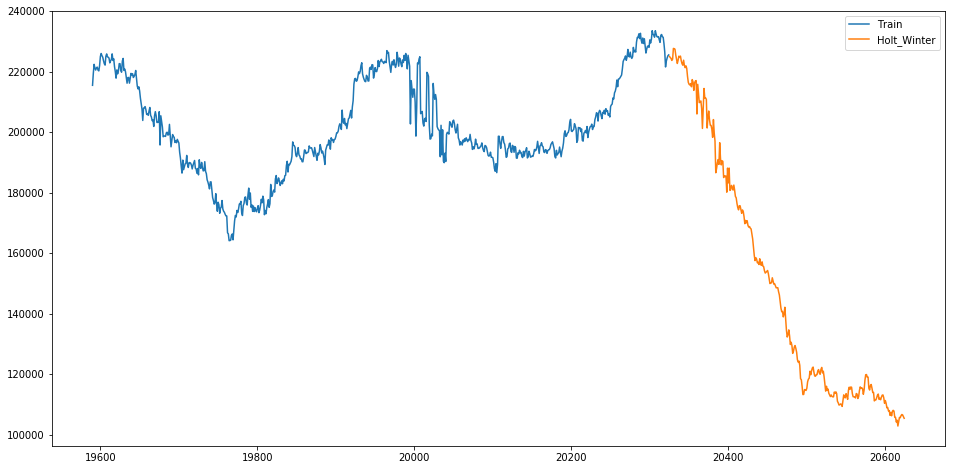

4


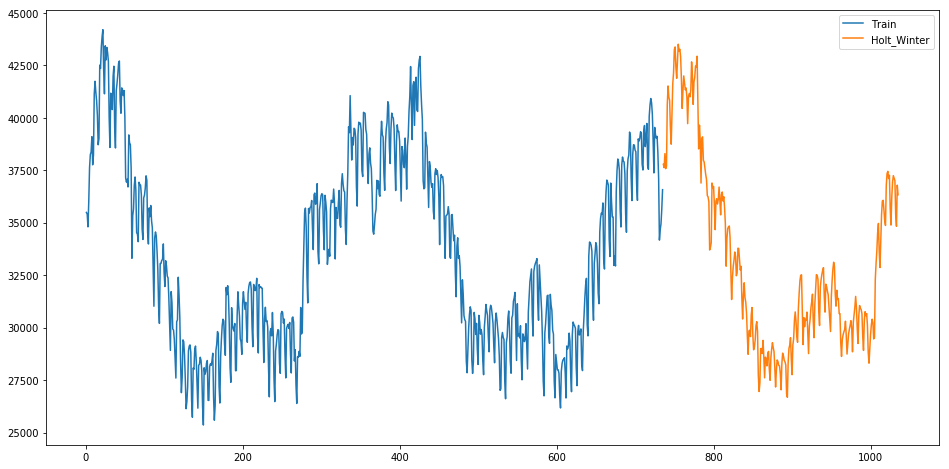

5


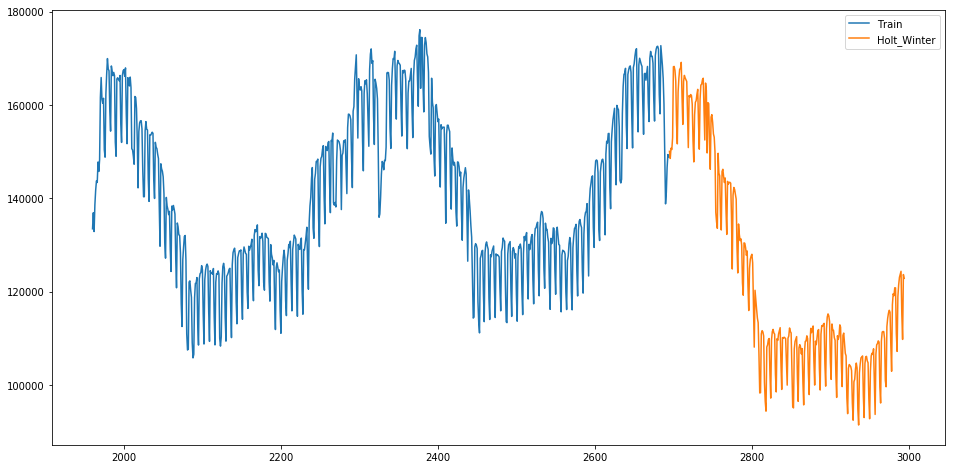

6


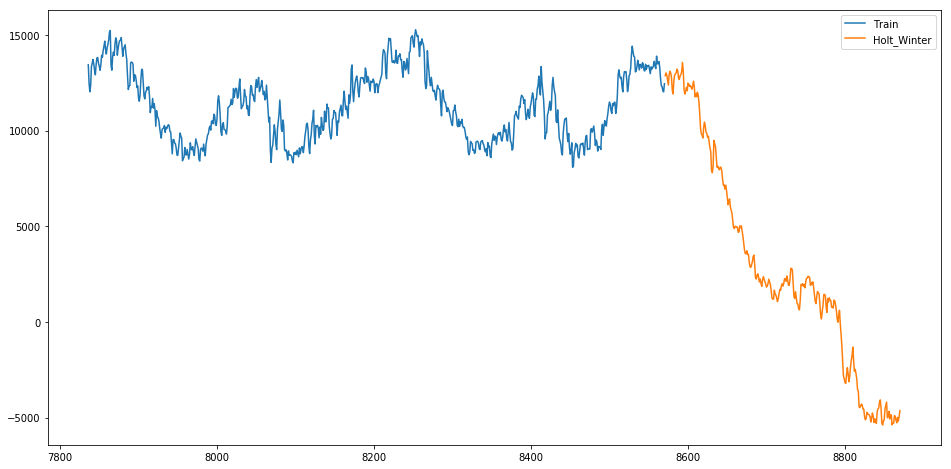

7


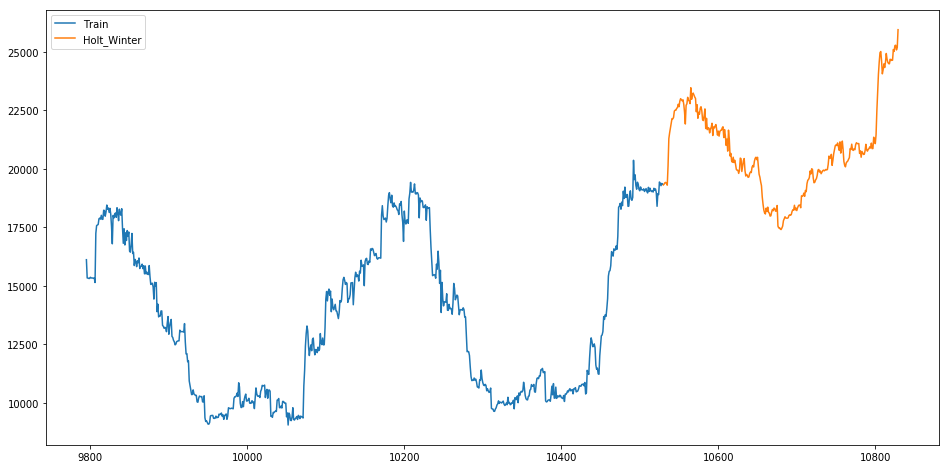

8


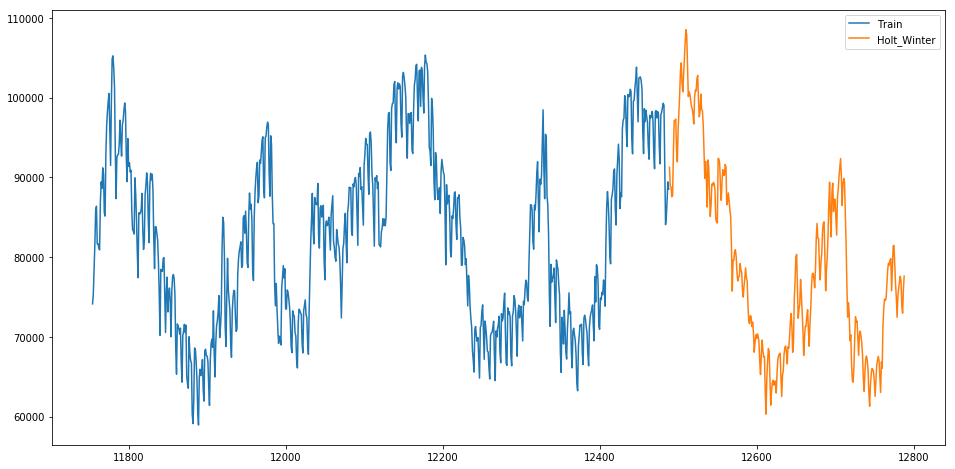

9


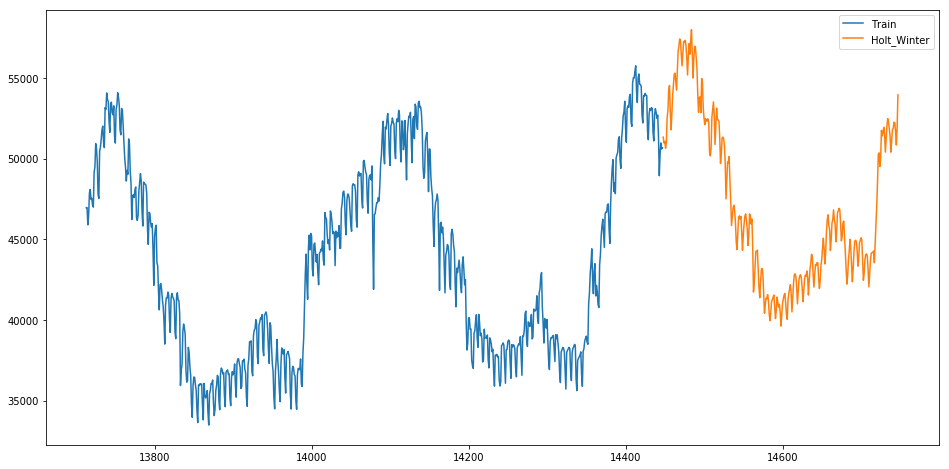

10


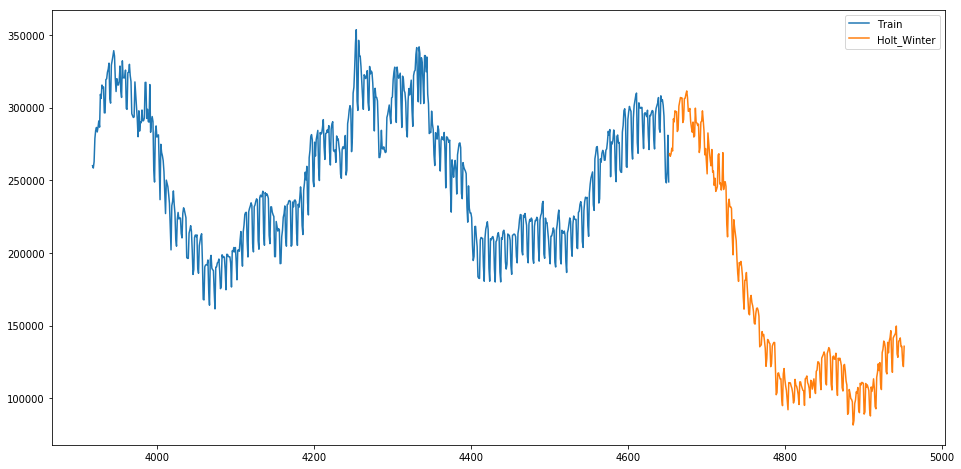

11


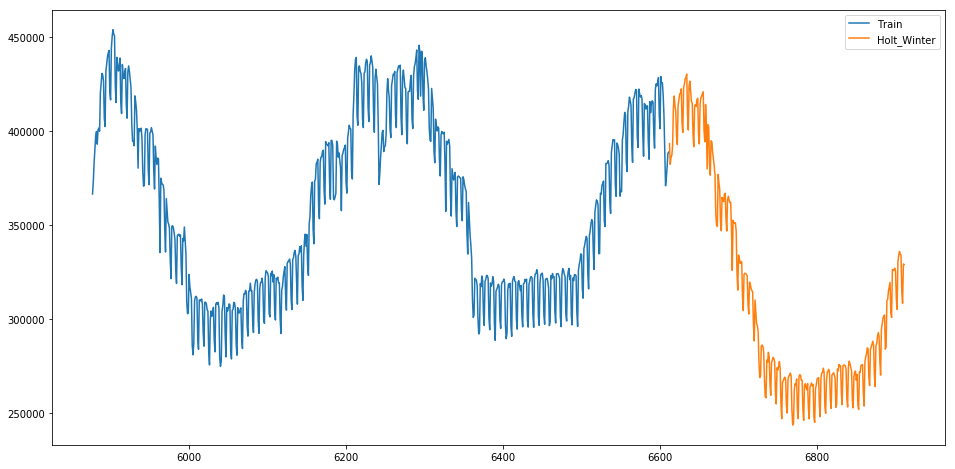

In [230]:
test_all = None
for i in range(1, 12):
    if test_all is None: 
        print(i)
        test_all = main(i, 365)
    else:
        print(i)
        test_all = test_all.append(main(i, 365))

12


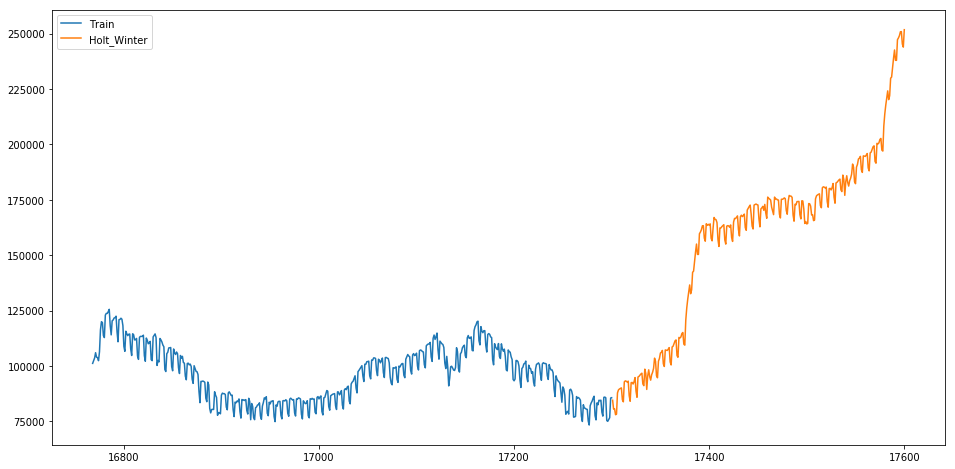

13


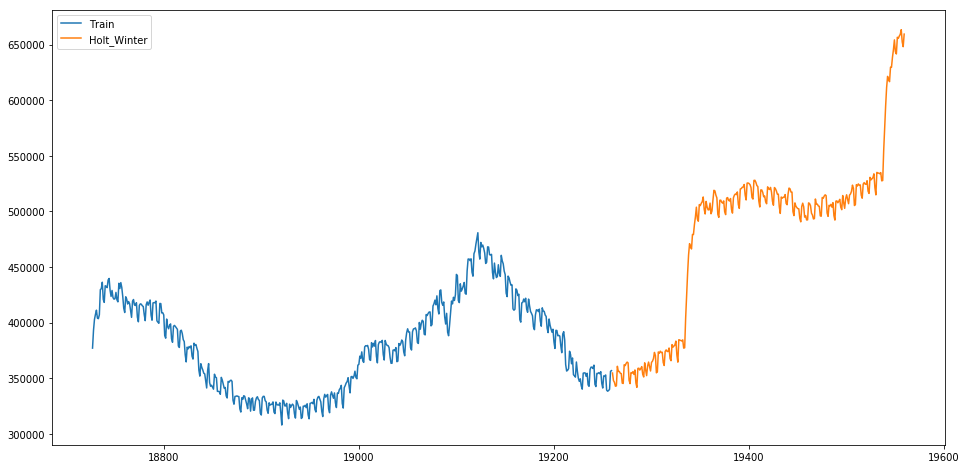

14


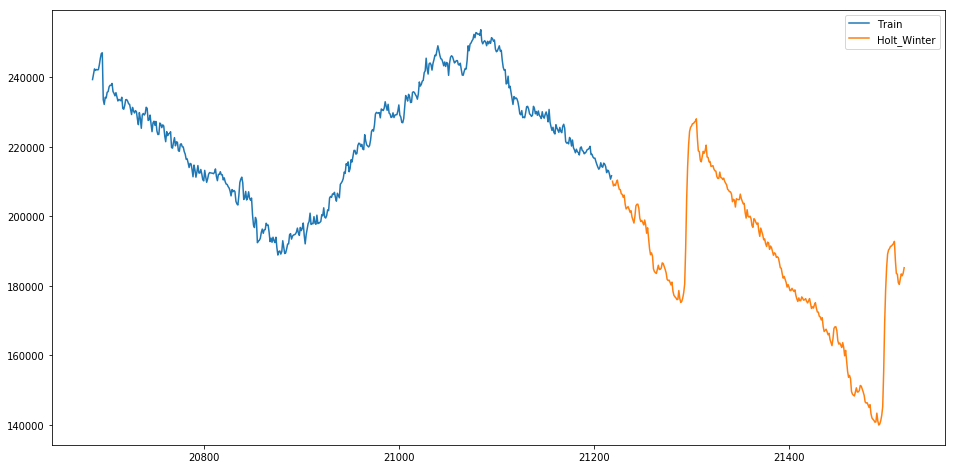

15


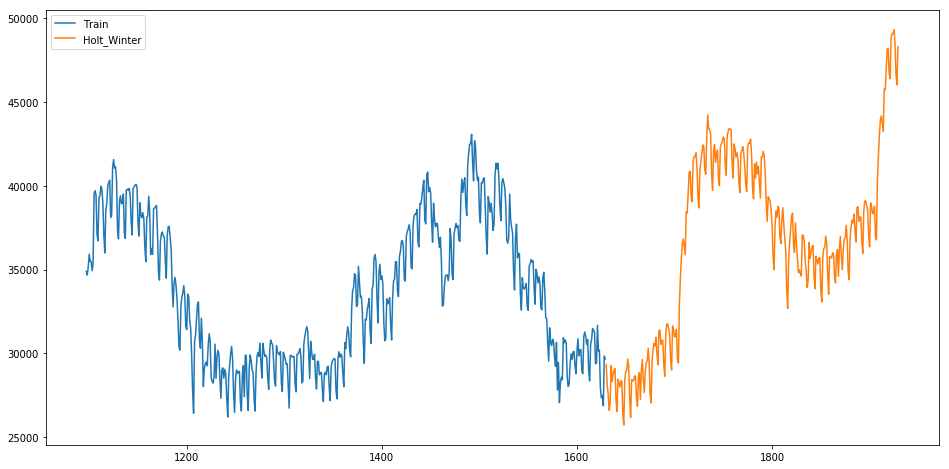

16


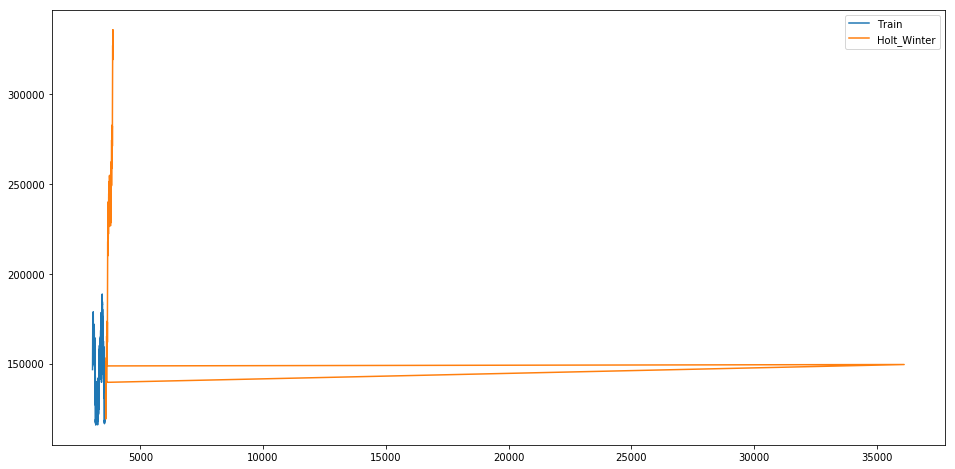

17


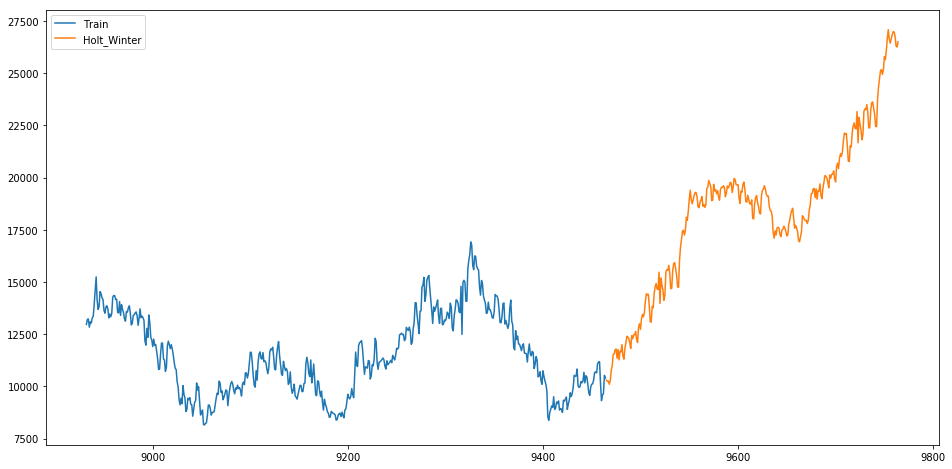

18


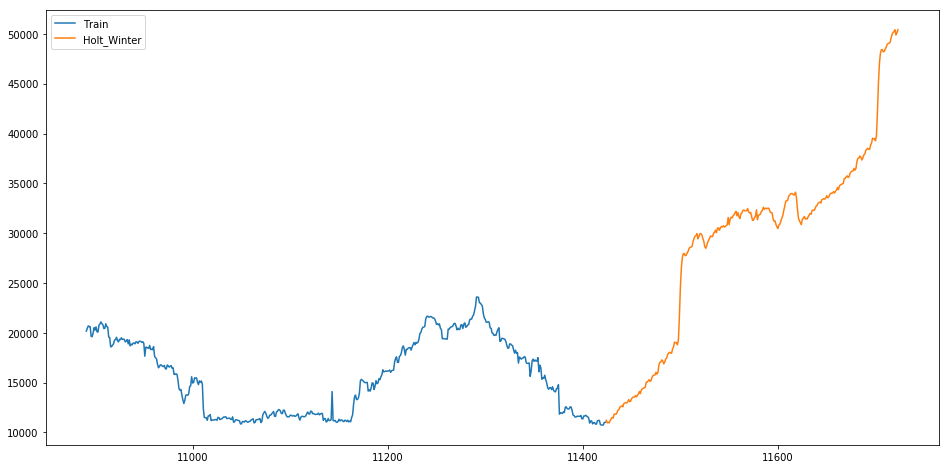

19


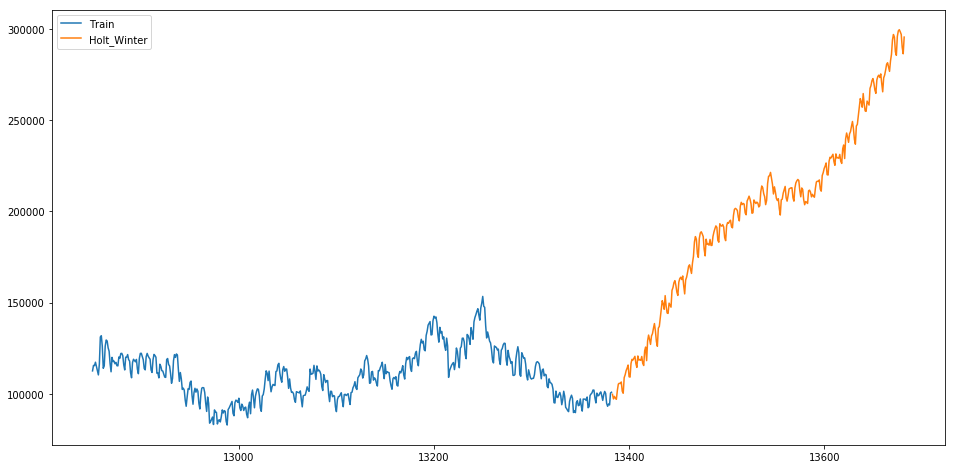

20


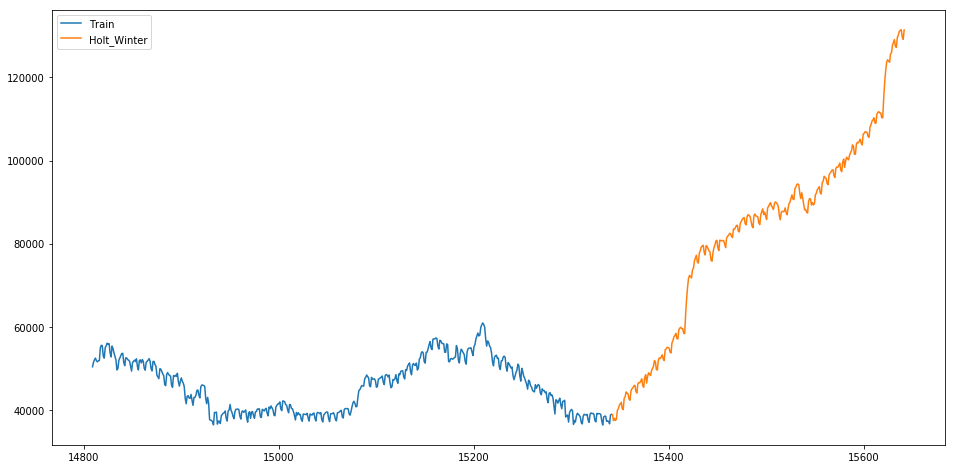

21


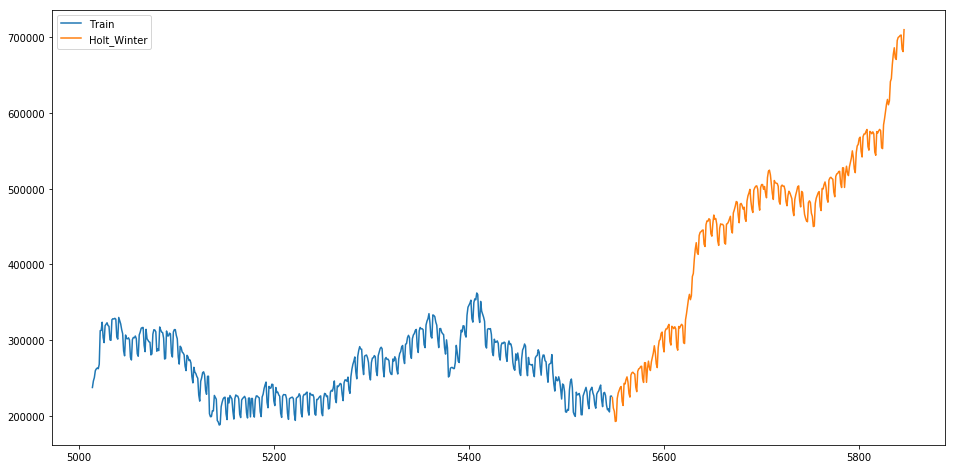

22


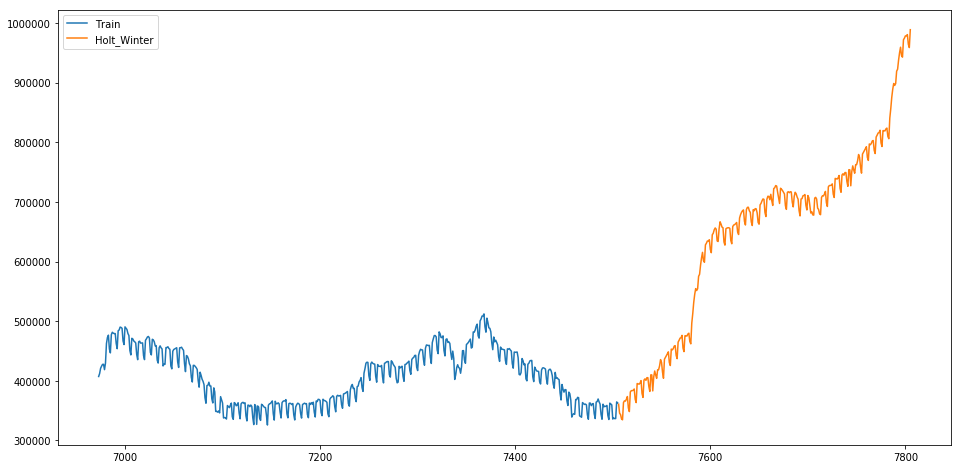

In [231]:
for i in range(12, 23):
    print(i)
    test_all = test_all.append(main(i, 203))